In [5]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sr
from sklearn.random_projection import sparse_random_matrix as srmat
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
np.random.seed(1337)
import time

In [6]:
def simplex_projection(s):
    if np.sum(s) <=1 and np.alltrue(s >= 0):
        return s
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u)+1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1.0)
    return np.maximum(s-theta, 0)

def nuclear_projection(A):
    U, s, V = np.linalg.svd(A, full_matrices=False)
    s = simplex_projection(s)
    return U.dot(np.diag(s).dot(V))
    
def convergence_plot(A,Xfw,Xp,obj):
    
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.title('Convergence in objective')    
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale('log')
    fs1 = [obj(X) for X in Xfw]
    fs2 = [obj(X) for X in Xp]
    plt.plot(range(len(fs1)), fs1, label='Frank-Wolfe')
    plt.plot(range(len(fs2)), fs2, label='Projected-GD')    
    plt.legend()
    
    plt.subplot(122)
    plt.title('Convergence in domain')    
    plt.xlabel('Step')
    plt.yscale('log')
    gs1 = [np.linalg.norm(A-X, 'fro')**2 for X in Xfw]
    gs2 = [np.linalg.norm(A-X, 'fro')**2 for X in Xp]
    plt.plot(range(len(gs1)), gs1, label='Frank-Wolfe')
    plt.plot(range(len(gs2)), gs2, label='Projected-GD')  
    plt.legend()
    plt.tight_layout()
    

def projected_gd(init, step, grad, obj, epi, proj=lambda x: x):
    xs = [init]
    ys = obj(xs[-1])
    yo = ys.copy()
    start = time.perf_counter()
    time_flag = True
    while True:
        xs.append(proj(xs[-1] - step * grad(xs[-1])))
        ys = obj(xs[-1])
        if (np.abs(ys-yo) < epi):
            break
        yo = ys.copy()
        if(time_flag and yo<1e-4):
            print('PGD Time elasped to 1e-4 Error:',time.perf_counter()-start)
            time_flag = False
    return xs

def mc_objective(Y, O, X):

    return 0.5 * np.linalg.norm(Y-np.multiply(X, O), 'fro')**2

def mc_gradient(Y, O, X):

    return np.multiply(X, O) - Y

def frank_wolfe(init, oracle, grad, obj, epi, back_tracking=False):
    xs = [init]
    ys = obj(xs[-1])
    yo = ys.copy()
    step_0 = 1
    start = time.perf_counter()
    time_flag = True
    while True:
        if back_tracking:
            beta = 0.1
            step = step_0
            gs = grad(xs[-1])
            # gs = oracle(xs[-1])-xs[-1]
            while (obj(xs[-1]-step*gs) > yo-0.5*step*(np.linalg.norm(gs)**2)):
                step = beta*step
            step_0 = step

        else:
            step = 2./(len(xs)+1.)
        xs.append(xs[-1] + step*(oracle(xs[-1])-xs[-1]))
        ys = obj(xs[-1])
        if (np.abs(ys-yo) < epi):
            break
        yo = ys.copy()
        if(time_flag and yo<1e-4):
            print('FW Time elasped to 1e-4 Error:',time.perf_counter()-start)
            time_flag = False
    return xs

def power_method(A, num_steps=10):

    m, n = A.shape
    x = np.random.normal(0,1, m)
    x /= np.linalg.norm(x)
    y = A.T.dot(x)
    y /= np.linalg.norm(y)
    for _ in range(num_steps):      
        x = A.dot(y)
        x /= np.linalg.norm(x)
        y = A.T.dot(x)
        y /= np.linalg.norm(y)        
    return x, y

def mc_oracle(Y, O, X):

    G = mc_gradient(Y, O, X)
    x, y = power_method(-G)
    return x.reshape((len(x), 1)).dot(y.reshape((1,len(y))))

In [7]:
def FW_vs_PGD(n,k):
    # n, k = 500, 15
    U = np.random.normal(0, 1, (n, k))
    U = np.linalg.qr(U)[0]
    S = np.diag(np.random.uniform(0, 1, k))
    S /= np.sum(S)
    A = U.dot(S.dot(U.T))
    O = np.random.randint(0,2, (n, n))
    Y = np.multiply(A, O)
    epi = 1e-10
    X0 = np.random.normal(0,1, (n,n))
    X0 = nuclear_projection(X0.dot(X0.T))

    objective = lambda X: mc_objective(Y, O, X)
    gradient = lambda X: mc_gradient(Y, O, X)
    oracle = lambda X: mc_oracle(Y, O, X)

    Xfw = frank_wolfe(X0.copy(), oracle, gradient, objective, epi, back_tracking=False)
    Xp = projected_gd(X0.copy(), 0.2, gradient, objective, epi, nuclear_projection)
    convergence_plot(A,Xfw,Xp,objective)

    tsvd = TruncatedSVD(n_components=50, n_iter=10, random_state=42)
    tsvd.fit(A)
    S_opt = tsvd.singular_values_

    tsvd = TruncatedSVD(n_components=50, n_iter=10, random_state=42)
    tsvd.fit(Xfw[-1])
    Sfw = tsvd.singular_values_

    tsvd = TruncatedSVD(n_components=50, n_iter=10, random_state=42)
    tsvd.fit(Xp[-1])
    Sp = tsvd.singular_values_

    plt.figure(figsize=(14,6))
    plt.title('Largest 20 singular values of recovered solution')
    plt.plot(range(20), np.sort(Sfw)[::-1][:20], 'o-', label='recovered(Frank-Wolfe)')
    plt.plot(range(20), np.sort(Sp)[::-1][:20], 'o-', label='recovered(Projected-GD)')
    plt.plot(range(20), np.sort(S_opt)[::-1][:20], 'o-', label='optimal')
    plt.legend()


FW Time elasped to 1e-4 Error: 0.07379893500183243
PGD Time elasped to 1e-4 Error: 0.16682854700047756


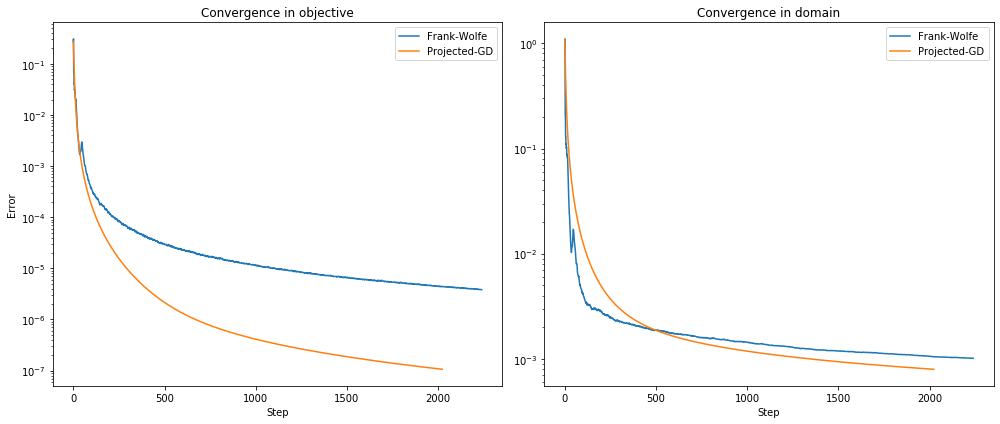

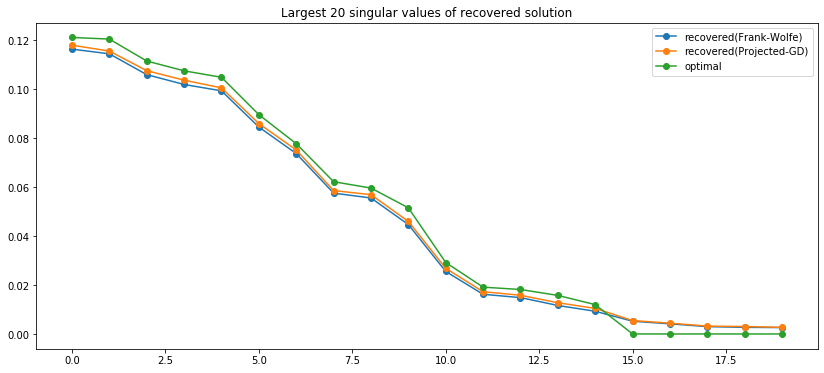

In [8]:
FW_vs_PGD(100,15)

FW Time elasped to 1e-4 Error: 0.314084798003023
PGD Time elasped to 1e-4 Error: 1.1585031450013048


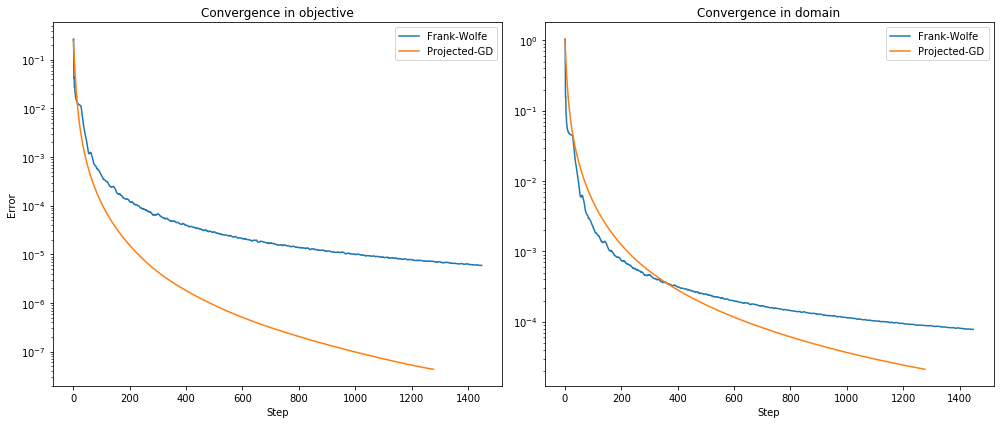

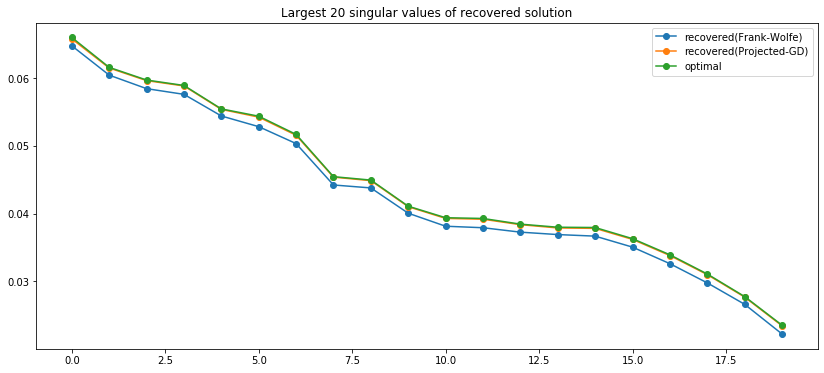

In [9]:
FW_vs_PGD(300,30)

FW Time elasped to 1e-4 Error: 1.2364717780001229
PGD Time elasped to 1e-4 Error: 7.324935921002179


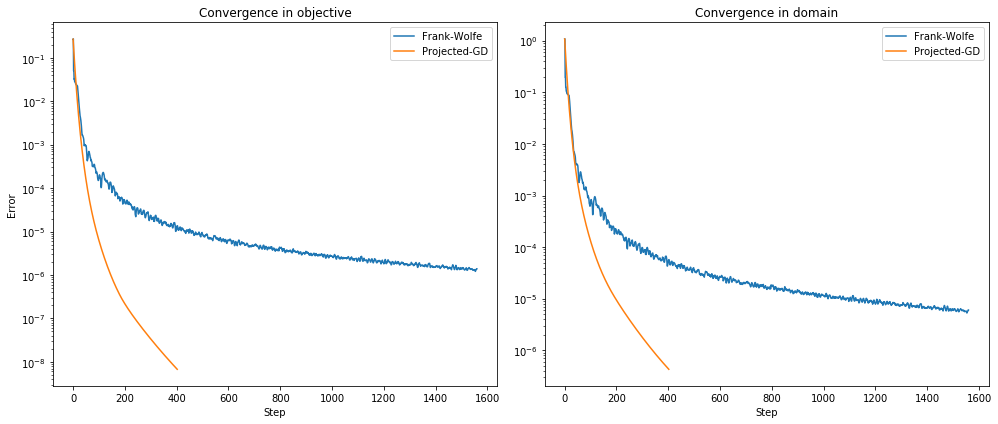

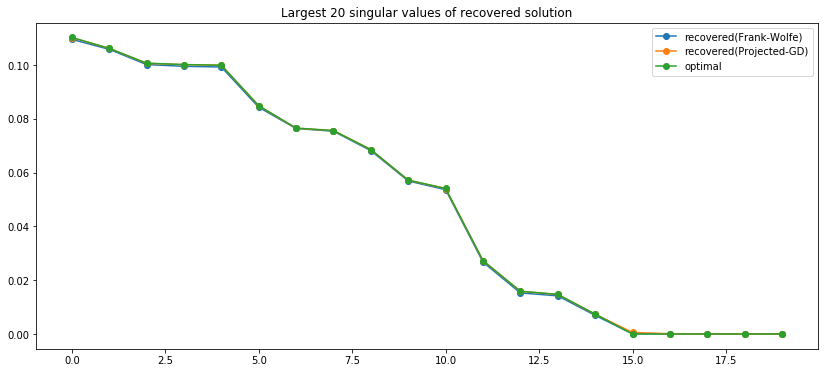

In [10]:
FW_vs_PGD(1000,15)